# ColorHandPose3D Demo

This notebook demos the ColorHandPose3d network as implemented in "Learning to Estimate 3D Hand Pose from Single RGB Images" by Zimmerman et al. Their project is available at [https://github.com/lmb-freiburg/hand3d].

In [1]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.ColorHandPose3D import ColorHandPose3D
from colorhandpose3d.utils.general import *
from colorhandpose3d.utils.transforms import *

## Initialize models and load weights

ColorHandPose3d consists of 4 networks:
- HandSegNet
- PoseNet
- PosePrior
- ViewPointNet

In [2]:
chp3d = ColorHandPose3D()

## Load and run sample

The network is trained on the RHD dataset.

In [5]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize(256)
img = Image.open('/home/ajdillhoff/Downloads/RHD_v1-1/RHD_published_v2/training/color/00007.png')
sample_original = transform1(transform2(img)).unsqueeze(0)
sample = sample_original - 0.5
hand_side = torch.Tensor([[1, 0]])

# Run through network
coords_xyz_rel_normed, keypoint_scoremap, image_crop, centers, scale_crop = chp3d(sample, hand_side)
keypoint_coords3d = coords_xyz_rel_normed.detach().numpy()
keypoint_coords3d = keypoint_coords3d.squeeze()

## Visualizing the output

Display the crop, heatmaps, and estimated pose.

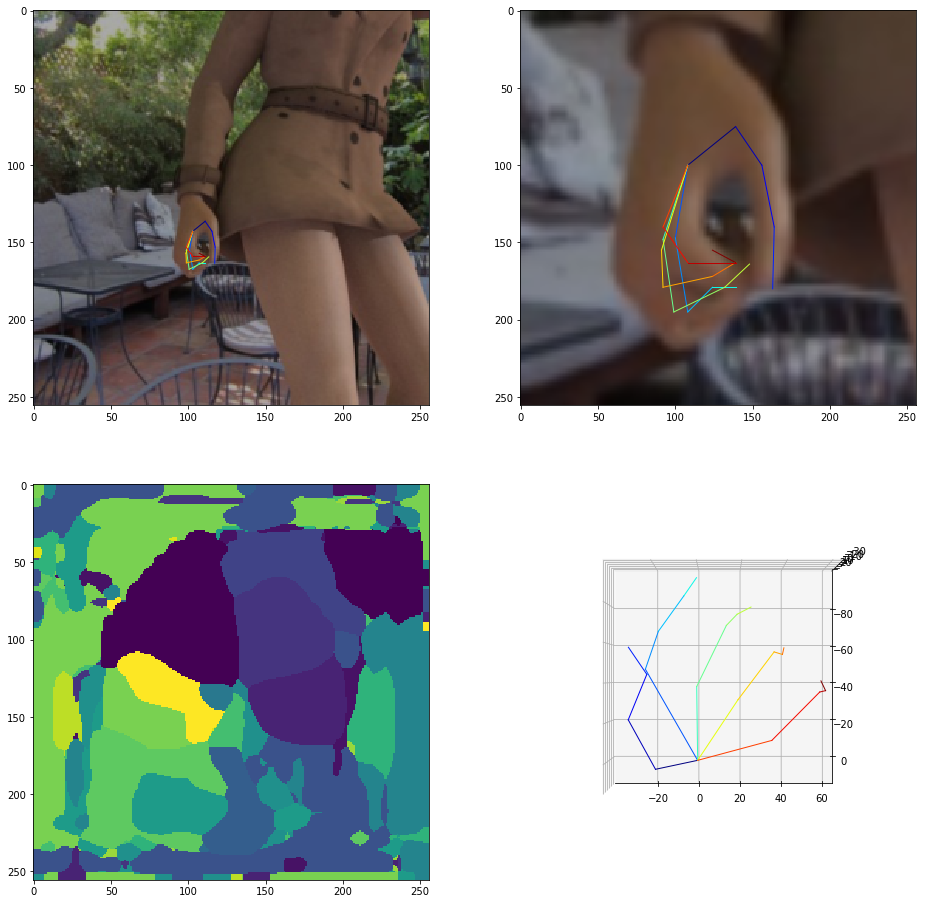

In [6]:
# Get other things to visualize
keypoint_coords_crop = detect_keypoints(keypoint_scoremap[0].detach().numpy())
keypoint_coords = transform_cropped_coords(keypoint_coords_crop, centers, scale_crop, 256)

img = transform0(sample_original.squeeze())

# visualize
fig = plt.figure(1, figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224, projection='3d')
ax1.imshow(img)
plot_hand(keypoint_coords, ax1)
ax2.imshow(transform0(image_crop[0] + 0.5))
plot_hand(keypoint_coords_crop, ax2)
ax3.imshow(np.argmax(keypoint_scoremap[0].detach().numpy(), 0))
plot_hand_3d(keypoint_coords3d, ax4)
ax4.view_init(azim=-90.0, elev=-90.0)  # aligns the 3d coord with the camera view
plt.show()